# Herschel Stripe 82 master catalogue
## Preparation of VISTA/CFHT Telescope / VIRCAM/WIRCAM Camera data

VISTA/CFHT Telescope / VIRCAM/WIRCAM Camera VICS82 catalogue: the catalogue comes from `dmu0_VICS82`.

The catalogue is described here: https://arxiv.org/pdf/1705.05451.pdf

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The magnitude for each band.
- The auto magnitude to be used as total magnitude .



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]
This notebook was executed on: 
2018-02-27 13:24:21.212625


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux, ebv

from herschelhelp.database import get_filters

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "vics82_ra"
DEC_COL = "vics82_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'VICS82ID': "vics82_id",
        'ALPHA_J2000': "vics82_ra",
        'DELTA_J2000': "vics82_dec",
        'CLASS_STAR':  "vics82_stellarity",
        'MAG_AUTO': "m_vics82_ks", 
        'MAG_APER': "m_ap_vics82_ks", 
        'JMAG_AUTO': "m_vics82_j", 
        'JMAG_APER': "m_ap_vics82_j", 
        'IMAGE': 'image_name',
})

#No error column?

catalogue = Table.read("../../dmu0/dmu0_VICS82/data/VICS82_FULL_SDSS_FEB2017_K22_HELP-coverage_intIDs.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2011

# Clean table metadata
catalogue.meta = None

#replace list of aperture magnitudes with appropriate choice from list
# Apertures (1", 1.5", 2", 2.5" and 3"
catalogue["m_ap_vics82_j"] = catalogue["m_ap_vics82_j"][:, 2]
catalogue["m_ap_vics82_ks"] = catalogue["m_ap_vics82_ks"][:, 2]
#catalogue["m_ap_vics82_j"]  = [el[0] for el in catalogue["m_ap_vics82_j"] ]
#catalogue["m_ap_vics82_j"]  = [el[0] for el in catalogue["m_ap_vics82_j"] ]

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        # Add err col with all nan values because errors absent
        errcol = "merr{}".format(col[1:])
        nan_values = np.empty(len(catalogue))
        nan_values[:] = np.NAN
        catalogue.add_column(Column(nan_values, name=errcol))
        
        # Some object have a magnitude to 0 or 99., we suppose this means missing value
        mask = ((catalogue[col] <= 0) |
                (catalogue[errcol] <= 0) |
                (catalogue[col] > 50.))
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask] = np.nan  
        

        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)


In [6]:
catalogue[:10].show_in_notebook()

idx,vics82_id,vics82_ra,vics82_dec,vics82_stellarity,m_vics82_ks,m_ap_vics82_ks,m_vics82_j,m_ap_vics82_j,image_name,merr_vics82_ks,f_vics82_ks,ferr_vics82_ks,flag_vics82_ks,merr_ap_vics82_ks,f_ap_vics82_ks,ferr_ap_vics82_ks,merr_vics82_j,f_vics82_j,ferr_vics82_j,flag_vics82_j,merr_ap_vics82_j,f_ap_vics82_j,ferr_ap_vics82_j
0,VICS82J000000.00-002426.2,4.38503205524e-07,-0.40727797226,0.439048498869,23.1142292023,24.527,nan,nan,C.10.Ks.fits,nan,2.06209333761,nan,False,nan,0.56129,nan,nan,nan,nan,False,nan,nan,nan
1,VICS82J000000.00+001719.7,1.11189935936e-06,0.28879645815,0.393842220306,23.0351219177,nan,nan,nan,C.05.Ks.fits,nan,2.21794735168,nan,False,nan,nan,nan,nan,nan,nan,False,nan,nan,nan
2,VICS82J000000.00-000635.7,3.23150055392e-06,-0.109913593316,0.0344451516867,23.5379753113,25.5243,nan,nan,C.10.Ks.fits,nan,1.39575719568,nan,False,nan,0.224024,nan,nan,nan,nan,False,nan,nan,nan
3,VICS82J000000.00-000912.8,3.38169190306e-06,-0.153541727276,0.037895578891,22.9763355255,23.4395,nan,nan,C.10.Ks.fits,nan,2.34134703553,nan,False,nan,1.52826,nan,nan,nan,nan,False,nan,nan,nan
4,VICS82J000000.00-001700.9,3.49929820231e-06,-0.283591631126,0.358299702406,21.3763198853,21.2107,nan,nan,C.09.Ks.fits,nan,10.2204977251,nan,False,nan,11.9053,nan,nan,nan,nan,False,nan,nan,nan
5,VICS82J000000.00-003721.0,4.28460541424e-06,-0.622491102849,0.360982358456,22.0553379059,23.0176,nan,nan,C.10.Ks.fits,nan,5.46845745532,nan,False,nan,2.2541,nan,nan,nan,nan,False,nan,nan,nan
6,VICS82J000000.00-001634.9,5.29322761622e-06,-0.276361383784,0.816997587681,18.5102806091,18.8293,19.576915741,19.9758,C.09.Ks.fits,nan,143.181779734,nan,False,nan,106.733,nan,nan,53.6085059317,nan,False,nan,37.1262,nan
7,VICS82J000000.00-001758.2,5.90097545228e-06,-0.299503046188,0.498833566904,21.3774375916,21.2169,nan,nan,C.09.Ks.fits,nan,10.2099816931,nan,False,nan,11.8375,nan,nan,nan,nan,False,nan,nan,nan
8,VICS82J000000.00-010228.5,6.69776278472e-06,-1.04125178718,0.976375043392,17.7089519501,17.8036,17.6998195648,17.8732,C.10.Ks.fits,nan,299.515443323,nan,False,nan,274.512,nan,nan,302.045363865,nan,False,nan,257.464,nan
9,VICS82J000000.00-003838.1,8.21837221565e-06,-0.643921912328,0.448814690113,22.3866500854,22.206,nan,nan,C.09.Ks.fits,nan,4.03032404732,nan,False,nan,4.75971,nan,nan,nan,nan,False,nan,nan,nan


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['m_ap_vics82_j', 'm_ap_vics82_ks']
FLAG_NAME = 'vics82_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 15318703 sources.
The cleaned catalogue has 13914761 sources (1403942 removed).
The cleaned catalogue has 1239734 sources flagged as having been cleaned


## Determination of camera used
Using the service at https://apps.automeris.io/wpd/ I extracted positions from Figure 2 in the VICS82 paper.

![VICS82](../../dmu0/dmu0_VICS82/regions.png)

The positions from right to left are below in decimal hours in x and decimal degrees in y:

<pre>
positions= [
    [-0.3135593220338988, -0.0710346572223628],
    [0.8983050847457625, 0.06283835061978316],
    [0.9915254237288131, 0.004249936756892225],
    [1.3855932203389827, 0.008955223880596108],
    [1.4533898305084745, 0.2485707057930675],
    [1.4872881355932202, 0.24897546167467688],
    [2.3644067796610164, 0.02064254996205328],
]
</pre>

which can be roughly cut using

<pre>
#Is the objects in the grey region between ih and 23h?
in_region1 = ((catalogue[RA_COL] > (360. + positions[0][0]*15.) )
              | (catalogue[RA_COL] < positions[1][0]*15. )
              | ( (catalogue[RA_COL] < positions[2][0]*15. ) & (catalogue[DEC_COL] < positions[2][1]*15. ))
             )
          
#Small aquare at 1.4 hrs
in_region2 = (((catalogue[RA_COL] > positions[3][0]*15.) & (catalogue[RA_COL] < positions[4][0]*15.))
              | ((catalogue[DEC_COL] > positions[4][1]*15.) & (catalogue[RA_COL] > positions[4][0]*15.) & (catalogue[RA_COL] < positions[5][0]*15.))
)

#REgion at far left beyond 2.4 hr
in_region3 = ((catalogue[RA_COL] > positions[6][0]*15.) & (catalogue[RA_COL] < 50.))

cfht = in_region1 | in_region2 | in_region3
</pre>

However, Jim Geach informed us that the camera can be found by taking teh image name which contains a flag for the camera used.

In [8]:
cfht = np.char.array(catalogue['image_name'].astype(str)).startswith('C')

In [9]:



column_bases = ['f', 'ferr', 'm', 'merr', 'flag', 'f_ap', 'ferr_ap', 'm_ap', 'merr_ap']
bands = ['j', 'ks']

for band in bands:
    for col_base in column_bases:
        catalogue.add_column(Column(data=catalogue[col_base + '_vics82_' + band], 
                                    name = col_base + '_wircam_' + band))   
        if col_base == 'flag':
            catalogue[col_base + '_wircam_' + band][~cfht] = False
        else:
            catalogue[col_base + '_wircam_' + band][~cfht] = np.nan
        catalogue.add_column(Column(data=catalogue[col_base + '_vics82_' + band], 
                                    name = col_base + '_vista_' + band))
        if col_base == 'flag':
            catalogue[col_base + '_vista_' + band][cfht] = False
        else:
            catalogue[col_base + '_vista_' + band][cfht] = np.nan
        catalogue.remove_column(col_base + '_vics82_' + band)

print("There were {} CFHT fluxes and {} VISTA fluxes out of {} total.".format(np.sum(cfht), 
                                                                              np.sum(~cfht), 
                                                                              len(catalogue)))


catalogue.remove_column('image_name')

There were 8491993 CFHT fluxes and 5422768 VISTA fluxes out of 13914761 total.


In [10]:
catalogue[:10].show_in_notebook()

idx,vics82_id,vics82_ra,vics82_dec,vics82_stellarity,vics82_flag_cleaned,f_wircam_j,f_vista_j,ferr_wircam_j,ferr_vista_j,m_wircam_j,m_vista_j,merr_wircam_j,merr_vista_j,flag_wircam_j,flag_vista_j,f_ap_wircam_j,f_ap_vista_j,ferr_ap_wircam_j,ferr_ap_vista_j,m_ap_wircam_j,m_ap_vista_j,merr_ap_wircam_j,merr_ap_vista_j,f_wircam_ks,f_vista_ks,ferr_wircam_ks,ferr_vista_ks,m_wircam_ks,m_vista_ks,merr_wircam_ks,merr_vista_ks,flag_wircam_ks,flag_vista_ks,f_ap_wircam_ks,f_ap_vista_ks,ferr_ap_wircam_ks,ferr_ap_vista_ks,m_ap_wircam_ks,m_ap_vista_ks,merr_ap_wircam_ks,merr_ap_vista_ks
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,VICS82J233057.34+010114.3,352.738915284,1.02064739539,0.998761177063,False,nan,121909.727525,nan,nan,nan,11.1849040985,nan,nan,False,False,nan,40653.7,nan,nan,nan,12.3773,nan,nan,nan,53915.8316522,nan,nan,nan,12.0707092285,nan,nan,False,False,nan,27316.1,nan,nan,nan,12.809,nan,nan
1,VICS82J233057.32+010112.9,352.738846566,1.02025121012,0.999135792255,False,nan,121909.727525,nan,nan,nan,11.1849040985,nan,nan,False,False,nan,40653.7,nan,nan,nan,12.3773,nan,nan,nan,29444.062196,nan,nan,nan,12.7275056839,nan,nan,False,False,nan,17334.7,nan,nan,nan,13.3027,nan,nan
2,VICS82J233715.62-000637.3,354.315065697,-0.110356292614,0.996454775333,False,nan,80768.1371822,nan,nan,nan,11.6318998337,nan,nan,False,False,nan,38773.6,nan,nan,nan,12.4287,nan,nan,nan,66859.1933881,nan,nan,nan,11.837097168,nan,nan,False,False,nan,42931.7,nan,nan,nan,12.3181,nan,nan
3,VICS82J233307.98-001458.9,353.283258686,-0.249696492185,0.99839258194,False,nan,88082.1071066,nan,nan,nan,11.5377807617,nan,nan,False,False,nan,37884.7,nan,nan,nan,12.4538,nan,nan,nan,55126.8651452,nan,nan,nan,12.0465917587,nan,nan,False,False,nan,37467.2,nan,nan,nan,12.4659,nan,nan
4,VICS82J233254.96-001945.2,353.22901946,-0.32923286828,0.998426914215,False,nan,76446.5292573,nan,nan,nan,11.6916055679,nan,nan,False,False,nan,37570.2,nan,nan,nan,12.4629,nan,nan,nan,54019.4553882,nan,nan,nan,12.0686244965,nan,nan,False,False,nan,38426.0,nan,nan,nan,12.4384,nan,nan
5,VICS82J233307.81-002229.8,353.28252169,-0.37495515358,0.998830258846,False,nan,73369.2610273,nan,nan,nan,11.7362146378,nan,nan,False,False,nan,37388.7,nan,nan,nan,12.4681,nan,nan,nan,44475.3635562,nan,nan,nan,12.2797012329,nan,nan,False,False,nan,33256.4,nan,nan,nan,12.5953,nan,nan
6,VICS82J234241.88+004513.6,355.674483369,0.753774184241,0.757878661156,False,nan,173180.440642,nan,nan,nan,10.8037528992,nan,nan,False,False,nan,37336.8,nan,nan,nan,12.4697,nan,nan,nan,88840.3904063,nan,nan,nan,11.5284738541,nan,nan,False,False,nan,20938.2,nan,nan,nan,13.0977,nan,nan
7,VICS82J233206.81-001934.0,353.028377309,-0.326121964835,0.999757707119,False,nan,60876.0531339,nan,nan,nan,11.9388837814,nan,nan,False,False,nan,37327.1,nan,nan,nan,12.4699,nan,nan,nan,39666.2944004,nan,nan,nan,12.4039459229,nan,nan,False,False,nan,32083.8,nan,nan,nan,12.6343,nan,nan
8,VICS82J015708.81-002059.8,29.2867013575,-0.349958026886,0.913775086403,False,nan,111492.965506,nan,nan,nan,11.2818813324,nan,nan,False,False,nan,37235.0,nan,nan,nan,12.4726,nan,nan,nan,85864.4968046,nan,nan,nan,11.5654659271,nan,nan,False,False,nan,37784.2,nan,nan,nan,12.4567,nan,nan


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [11]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Herschel-Stripe-82.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

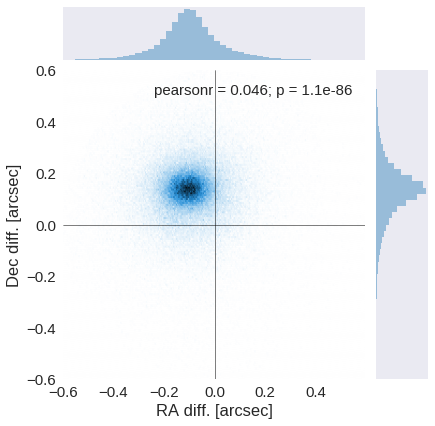

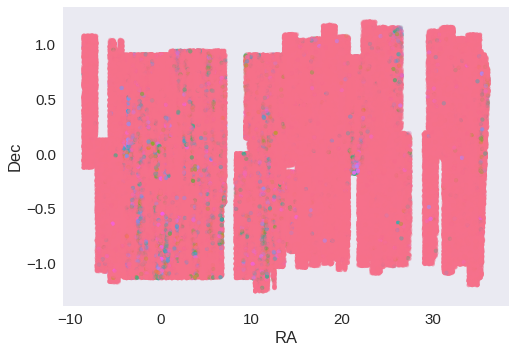

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

In [13]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords, near_ra0=True
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.09985838245256673 arcsec
Dec correction: -0.13517424260163224 arcsec


In [14]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

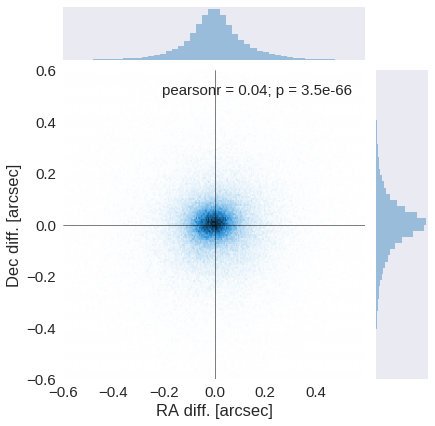

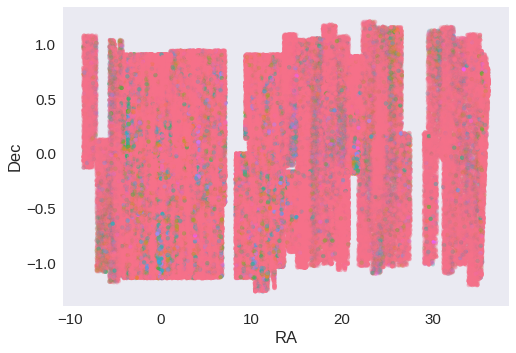

In [15]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## IV - Flagging Gaia objects

In [16]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [17]:
GAIA_FLAG_NAME = "vics82_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

194610 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [18]:
catalogue.write("{}/VICS82.fits".format(OUT_DIR), overwrite=True)